# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Get number of articles interacted with by user
user_art_interact = df.groupby('email').article_id.count().sort_values(ascending=False)
user_art_interact.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: article_id, dtype: int64

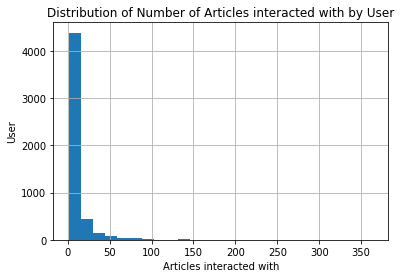

In [4]:
# Visualize distribution of number of articles interacted with by user
ax = user_art_interact.hist(bins=25)
ax.set_xlabel('Articles interacted with')
ax.set_ylabel('User')
ax.set_title('Distribution of Number of Articles interacted with by User');

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(user_art_interact) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = user_art_interact[0] # The maximum number of user-article interactions by any 1 user is ______.

print(f'50% of individuals interact with {median_val} number of articles or fewer.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content.duplicated().sum()

0

There are no completely identical rows in the df_content dataframe. However, when only taking into account the article_id, there are some duplicates:

In [7]:
df_content.duplicated(subset=['article_id']).sum()

5

In [8]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# The number of unique articles that have at least one interaction
unique_articles = len(df.article_id.unique()) 

# The number of unique articles on the IBM platform
total_articles = df_content.shape[0]

# The number of unique users
unique_users = len(df[df.email.notnull()].email.unique())

# The number of user-article interactions
user_article_interactions = df.shape[0]

print(f'a. The number of unique articles that have an interaction with a user = {unique_articles}')
print(f'b. The number of unique articles in the dataset (whether they have any interactions or not) = {total_articles}')
print(f'c. The number of unique users in the dataset (excluding null values) = {unique_users}')
print(f'd. The number of user-article interactions in the dataset = {user_article_interactions}')

a. The number of unique articles that have an interaction with a user = 714
b. The number of unique articles in the dataset (whether they have any interactions or not) = 1051
c. The number of unique users in the dataset (excluding null values) = 5148
d. The number of user-article interactions in the dataset = 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [10]:
# Get article_ids sorted by number of views
article_ids_by_views = df.groupby('article_id').email.count().sort_values(ascending=False)

# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(article_ids_by_views.index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = article_ids_by_views.values[0]

print(f'The most viewed article in the dataset as a string with one value following the decimal = {most_viewed_article_id}')
print(f'The most viewed article in the dataset was viewed how many times? = {max_views}')

The most viewed article in the dataset as a string with one value following the decimal = 1429.0
The most viewed article in the dataset was viewed how many times? = 937


In [11]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [12]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [13]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby('title').user_id.count().sort_values(ascending=False).index[:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    top_articles = list(df.groupby('article_id').user_id.count().sort_values(ascending=False).index[:n])
 
    return top_articles # Return the top article ids

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [15]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [16]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # Create user-item-matrix with 1 values for all interactions
    user_item = df[['article_id', 'user_id']].groupby(['user_id', 'article_id']).user_id.agg(lambda x: 1).unstack()
    
    # Replace NaN values with 0
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [17]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [18]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of the users in order from most to least similar
    
    '''
    # compute similarity of each user to the provided user
    similarities = user_item.apply(lambda x: np.dot(x, user_item.loc[user_id]), axis=1)
    
    # sort by similarity
    similarities.sort_values(ascending=False, inplace=True)

    # create list of just the ids
    most_similar_users = list(similarities.index)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [19]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [20]:
def get_article_names(article_ids, df=df, df_content=df_content):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    df_content - (pandas dataframe) df_content as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for id in article_ids:
        try:
            article_names.append(df[df.article_id == float(id)].title.values[0])
        except:
            # Some article ids are not in df, but in df_content
            article_names.append(df_content[df_content.article_id == float(id)].doc_full_name.values[0])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get list of ids for articles the user has already seen
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] == 1].index)
    
    # Convert data type of article ids to str
    article_ids = [str(x) for x in article_ids]
    
    # Get article names for those ids
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names 


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    
    # Loop through other users (most similar first)
    for other_user in find_similar_users(user_id):
        # Append ids for articles user has seen to recs
        recs.append(get_user_articles(other_user)[0])
        # Remove duplicate items from recs
        recs = list(np.unique(recs))
        # Break if desired number of recommendations is reached
        if len(recs) >= m:
            break
    
    # Reduce recs to desired number of recommendations
    recs = recs[:m]
      
    return recs # return your recommendations for this user_id    

In [21]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['access db2 warehouse on cloud and db2 with python',
 'tensorflow quick tips',
 'apache spark lab, part 1: basic concepts',
 'categorize urban density',
 'classify tumors with machine learning',
 'country statistics: life expectancy at birth',
 'finding optimal locations of new store using decision optimization',
 'gosales transactions for naive bayes model',
 'predict loan applicant behavior with tensorflow neural networking',
 'putting a human face on machine learning']

In [22]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Compute similarity for all users
    neighbors_df = pd.DataFrame(user_item.apply(lambda x: np.dot(x, user_item.loc[user_id]), axis=1), 
                                columns=['similarity'])
    
    # Compute number of articles viewed by each user
    neighbors_df['num_interactions'] = df.groupby('user_id').article_id.count()
    
    # Drop row with user_id we like to get sorted neighbors for
    neighbors_df.drop(user_id, inplace=True)
    
    # Create column for neighbor_id
    neighbors_df.reset_index(inplace=True)
    neighbors_df.rename(columns={'user_id' : 'neighbor_id'}, inplace=True)
    
    # Sort dataframe by similarity and then by number of interactions
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    # Return the dataframe specified in the doc_string
    return neighbors_df 


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    
    # Loop through other users absed on closeness
    for neighbor_id in get_top_sorted_users(user_id).neighbor_id.values:
        # Get ids for all articles the neighbor has interacted with
        neighbor_articles = get_user_articles(neighbor_id)[0]
        
        if len(neighbor_articles) + len(recs) <=  m:
            # Append all neighbor articles if there's enough room for all
            recs += neighbor_articles
        else:
            # Append only top articles to recs until limit m is reached
            for top_id in get_top_article_ids(unique_articles):
                if (top_id in neighbor_articles) and (top_id not in recs):
                    recs.append(article)
                if len(recs) >= m:
                    break
        if len(recs) >= m:
            return recs, get_article_names(recs)

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['232.0', '1271.0', '1280.0', '1320.0', '1328.0', '1402.0', '1403.0', '1410.0', '1320.0', '1366.0']

The top 10 recommendations for user 20 are the following article names:
['self-service data preparation with ibm data refinery', 'customer demographics and sales', 'education (2015): united states demographic measures', 'housing (2015): united states demographic measures', 'income (2015): united states demographic measures', 'uci: adult - predict income', 'uci: car evaluation', 'uci: sms spam collection', 'housing (2015): united states demographic measures', 'process events from the watson iot platform in a streams python application']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [25]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9] # Find the 10th most similar user to user 131

In [26]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

> Due to the 'cold start problem', it is not possible to make recommendations based on user-user based collaborative filtering (or any other form of collaborative filtering) for new users (or items), as without any information about the new user, we cannot find similar users.
>
> The only way to make recommendations for new users with the functions created above is to use the *get_top_articles()* function to give rank-based recommendations. However, these recommendations only include the top articles from all existing users, without any regards to the new users preferences (which we simply don't know).
>
> A possibly better way would be to use knowledge-based filtering and e.g. simply ask the user for some of his or her favorite items. Based on these items, we could e.g. compute users with similar preferences, and thus use user-user based collaborative filtering for our recommendations. Netflix e.g. is asking new users to choose a few top movies or series to be able to make recommendations.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [27]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(id) for id in get_top_article_ids(10)] # Your recommendations here


In [28]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [29]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
# Replace NaN values in doc_body column with doc_description values
df_content.loc[df_content.doc_body.isnull(), 'doc_body'] = df_content.doc_description

# Use doc_body column to create corpus
corpus = list(df_content.doc_body)

# Get stopwords
stop_words = stopwords.words("english")

# Initialize WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

In [31]:
def tokenize(text):
    '''
    INPUT:
    text - (str) text to tokenize
    
    OUTPUT:
    tokens - (list) tokens generated from text
    
    Description:
    Creates a list of tokens from a text by normalizing, tokenizing, removing stopwords 
    and lemmatizing an input text.
    '''
    
    # normalize case and remove punctuation and digits
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [32]:
# Initialize tf-idf vectorizer object
vectorizer = TfidfVectorizer(tokenizer=tokenize)

# Compute bag of word counts and tf-idf values
X = vectorizer.fit_transform(corpus)

# Create distance matrix for all articles based on cosine distance
X = X.toarray()
distance_matrix = pd.DataFrame(cdist(X, X, 'cosine'))

# Provide descriptive statistics of distance matrix
distance_matrix.describe()

,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
count,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,...,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,0.911478,0.927325,0.889691,0.942534,0.901193,0.927579,0.945386,0.916789,0.960053,0.904763,...,0.944288,0.932250,0.926799,0.972062,0.961481,0.969446,0.985655,0.937769,0.927107,0.892389
std,0.133624,0.049334,0.104463,0.063698,0.150938,0.054586,0.054731,0.048934,0.039031,0.065463,...,0.046684,0.053002,0.058153,0.036152,0.043689,0.056426,0.035151,0.058491,0.107185,0.089644
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.909891,0.908608,0.866427,0.936252,0.894717,0.914067,0.938613,0.892386,0.951338,0.875016,...,0.927077,0.908596,0.904520,0.967197,0.953022,0.967916,0.983801,0.925577,0.918190,0.851066
50%,0.949340,0.937169,0.921637,0.957585,0.945922,0.940535,0.956778,0.921846,0.968075,0.921071,...,0.955265,0.941242,0.940392,0.976796,0.969182,0.983763,0.992078,0.955295,0.960702,0.921707
75%,0.970117,0.956976,0.952779,0.973828,0.971338,0.956822,0.971170,0.946098,0.978221,0.949071,...,0.971423,0.965156,0.963493,0.984369,0.979244,0.991350,0.996245,0.969511,0.980815,0.953321
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
def get_top_articles_with_content(n, df=df, df_content=df_content):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    df_content - (pandas dataframe) df_content as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    # Order articles by number of interactions
    ordered_articles = list(df.groupby('article_id').user_id.count().sort_values(ascending=False))
    
    content_articles = df_content.article_id.values
    top_articles = []
    
    # Loop through ordered articles
    for article in ordered_articles:
        # Take only those articles that are in content_df
        if article in content_articles:
            top_articles.append(article)
        # Return the top article ids when n is reached
        if len(top_articles) >= n:    
            return top_articles 


def get_most_similar_item(article_id, s_dist=1, distance_matrix=distance_matrix):
    '''
    INPUT:
    article_id - (float) id of article to find similar item for
    s_dist - (int) wanted similarity distance (1: get most similar article, 2: get second most similar article...)
    
    OUTPUT:
    similar_item - (float) article_id of an article with similar content
    '''
    
    # Rank articles by distance to given article_id
    ranked_articles = list(distance_matrix[article_id].sort_values().index)
    
    return ranked_articles[s_dist]



def make_content_recs(user_id, n_recs):
    '''
    INPUT:
    user_id - (int) id of user to make recommendations for
    n_recs - (int) number of recommendations to make
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Computes n_recs content-based recommendations for a given user_id. If the user is new
    and hasn't interacted with any articles yet, half of the recommendations will be rank-based, 
    the other half content-based (most similar articles to the top ranked articles).
    
    '''
    recs = []
    
    # Get list of article_ids the user has already interacted with
    try:
        articles_read = get_user_articles(user_id)[0]
        articles_read = [float(x) for x in articles_read]
    except:
        articles_read = []
        
    # If user is new, make n_recs/2 rank-based recommendations
    if len(articles_read) < 1:
        top_articles = get_top_articles_with_content(n_recs//2)
        recs = top_articles 
        # Treat this articles as if they were read by user to make content-based recommendations
        articles_read += top_articles
        
    # Make recommendations by suggesting the most similar article to every article interacted with,
    # then the second most similar, third most similar etc. until n_recs recommendations are reached
    s_dist = 1
    
    while True:
        # Continuously loop through all articles interacted with
        for article_id in articles_read:
            
            # Check if article_id is in df_content, otherwise content-based recommendation is not possible
            if article_id in (df_content.article_id.unique()):
            
                # Get article with similar content
                rec_id = get_most_similar_item(article_id, s_dist)

                # Check if this article is has already been read or is already in recommendation list
                if (rec_id not in recs) and (rec_id not in articles_read):
                    recs.append(rec_id)

                # Stop when desired number of recommendations is reached
                if len(recs) >= n_recs:
                    return recs, get_article_names(recs)
        
        s_dist += 1

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**
>The recommendation system above makes content based recommendations by suggesting a user articles with similar content to the articles the users has already interacted with. 
>
>Content in this case is defined as the *doc_body* column from the *df_content* dataframe. For articles with NaN values in this column, the *doc_description* values are used instead.
>
>The content of all articles is first tokenized. As a next step, bag of word counts and tf-idf values are computed. Based on these tf-idf values, a distance matrix of all articles is created based on cosine distance. This matrix will be the basis for making recommendations for individual users.
>
>Recommendations for users are created with the *make_content_recs* function. The function takes a user id and the number of recommendations wanted and outputs a list of article ids as well as a list of titles of the desired number of recommendations.
>
>To cope with the cold start problem, the function first checks if the user has not interacted with any articles yet. In this case, half of the recommendations are provided rank based by recommending the articles with the most user interactions. These recommendations are then used as basis for making content based recommendations by recommending further articles with similar content to those most popular articles.
>
>In order to get rank based recommendations for users I first tried to re-use the *get_top_article_ids* function from part II. However, this didn't work, because many of the most popular articles where not part of the *df_content* dataframe, so it was not possible to generate further content based recommendations from those articles. To avoid this problem I wrote the new *get_top_articles_with_content* function, which gets only those most popular articles for which we have also content information.
>
>To make content based recommendations, the *make_content_recs* function continuosly loops through all articles the user has interacted with, uses the *get_most_similar_item* and thet distance matrix to find the one article that is most similar to the article already interacted with and adds it to the list of recommendations. It then adds the second most similar item to every article interacted with, then the third most similar item and so forth, until the desired number of recommendations is reached.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [34]:
# Make recommenddations for user with user_id 1
print('Top 10 Recommendations for an established User (user_id = 5154):\n')
print(f'Article IDs: {make_content_recs(1, 10)[0]}\n')
print('Article Headlines:')
for headline in make_content_recs(1, 10)[1]:
    print(headline)

Top 10 Recommendations for an established User (user_id = 5154):

Article IDs: [164, 509, 373, 39, 142, 886, 270, 793, 868, 891]

Article Headlines:
learn tensorflow and deep learning together and now!
Introduction to Graph Databases
working with notebooks in dsx
pulling and displaying etf data
neural networks for beginners: popular types and applications
Perform market basket analysis using dashDB and R
learning statistics on youtube
10 powerful features on watson data platform, no coding necessary
how to write the first for loop in r
interactive web apps with shiny cheat sheet


In [35]:
# Make recommendations for a brand new user
print('Top 10 Recommendations for a new User (user_id = 5154):\n')
print(f'Article IDs: {make_content_recs(5154, 10)[0]}\n')
print('Article Headlines:')
for headline in make_content_recs(5154, 10)[1]:
    print(headline)

# Make a recommendations for a user who has only interacted with article_id 1427.0
new_user = {'article_id' : 1427.0, 'title' : 'use xgboost, scikit-learn & ibm watson machine', 'user_id' : 5150}
df = df.append(new_user, ignore_index=True) # Add new user 5150 to df
make_content_recs(5150, 10)

print('\n\nTop 10 Recommendations for a who has only interacted with article_id 1427.0:\n')
print(f'Article IDs: {make_content_recs(5150, 10)[0]}\n')
print('Article Headlines:')
for headline in make_content_recs(5150, 10)[1]:
    print(headline)

Top 10 Recommendations for a new User (user_id = 5154):

Article IDs: [937, 927, 671, 643, 627, 603, 127, 719, 956, 90]

Article Headlines:
Who limits the rate-limiter? – IBM Watson Data Lab – Medium
Reading & Writing
Libraries and Tutorials
BigInsights on Cloud for Analysts
Importing Redis data into Compose Redis
Choosing a Cloudant Library – IBM Watson Data Lab – Medium
cloudant/meteor-couchdb
Data Migration & Transformation Tools
BigInsights on Cloud for Data Scientists
New Import for Compose MongoDB


Top 10 Recommendations for a who has only interacted with article_id 1427.0:

Article IDs: [937, 927, 671, 643, 627, 603, 127, 719, 956, 90]

Article Headlines:
Who limits the rate-limiter? – IBM Watson Data Lab – Medium
Reading & Writing
Libraries and Tutorials
BigInsights on Cloud for Analysts
Importing Redis data into Compose Redis
Choosing a Cloudant Library – IBM Watson Data Lab – Medium
cloudant/meteor-couchdb
Data Migration & Transformation Tools
BigInsights on Cloud for Data S

>The recommendations for both users are exactly the same simply because article_id 1427.0 is not in content_df and without article content it's impossible to make content-based recommendations. Because of this, for both users the first 5 recommendations are rank based and the second 5 recommendations are articles which have content similar to the 5 most popular articles (with content information available).

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [36]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [37]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [38]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**

>The problem with using traditional Singular Value Decomposition for making recommendations is that SVD doesn't work when the matrix it is used on has any missing values. However, this is usually the case when working with e.g. user rankings, as it was in the lesson with movie recommendations based on user rankings, as most users will not have given a rating for every single item in the matrix.
>
>In the lesson, we solved this problem by using FunkSVD, a variation of SVD that tolerates missing values.
>
>In the user-item-matrix above there are no missing values. As the matrix only contains information whether a certain user has interacted with a certain item or not, every cell in the matrix will always contain either the value 0 or 1. Therefore we can use traditional SVD here.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

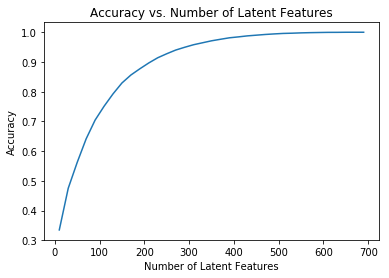

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item matrix for training and testing data
    user_item_train = df_train.groupby(['user_id', 'article_id']).user_id.agg(lambda x: 1).unstack().fillna(0)
    user_item_test = df_test.groupby(['user_id', 'article_id']).user_id.agg(lambda x: 1).unstack().fillna(0)
    
    # Get user and article ids for test data
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
# Get number of users from test data we can make predictions for based on train data
users_predictable = np.in1d(test_idx, user_item_train.index).sum()

# Get number of users from test data we cannot make predictions for based on train data
users_unpredictable = len(test_idx) - users_predictable

# Get number of items from test data we can make predictions for based on train data
items_predictable = np.in1d(test_arts, user_item_train.columns).sum()

# Get number of items from test data we cannot make predictions for based on train data
items_unpredictable = len(test_arts) - items_predictable

print(f'How many users can we make predictions for in the test set? = {users_predictable}')
print(f'How many users are we not able to make predictions for because of the cold start problem? = {users_unpredictable}')
print(f'How many articles can we make predictions for in the test set?  = {items_predictable}')
print(f'How many articles are we not able to make predictions for because of the cold start problem? = {items_unpredictable}')

How many users can we make predictions for in the test set? = 20
How many users are we not able to make predictions for because of the cold start problem? = 663
How many articles can we make predictions for in the test set?  = 574
How many articles are we not able to make predictions for because of the cold start problem? = 0


In [42]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [43]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [44]:
# Get subset of rows in the user_item_test dataset that we can predict using this matrix decomposition
user_item_test_subset = user_item_test[np.in1d(test_idx, user_item_train.index)]
user_item_test_subset.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Get user_ids for those users from test set we can make predictions for
test_user_ids = user_item_test_subset.index

# Get index of rows from training data for those users
test_user_rows = np.where(user_item_train.index.isin(test_user_ids))[0]

# Get index of columns from training data for items in test data
test_user_cols = np.where(user_item_train.columns.isin(test_arts))[0]

[3.0, 51.0, 69.0, 91.0, 101.0, 109.0, 120.0, 128.0, 145.0, 150.0, 159.0, 169.0, 179.0, 183.0, 187.0, 194.0, 195.0, 202.0, 205.0, 211.0, 214.0, 222.0, 223.0, 223.0, 225.0, 228.0, 230.0, 233.0, 235.0, 237.0, 240.0, 240.0, 240.0, 240.0, 242.0, 242.0, 242.0, 242.0, 243.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 244.0] [0.0, 10.0, 13.0, 21.0, 21.0, 21.0, 21.0, 22.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0]


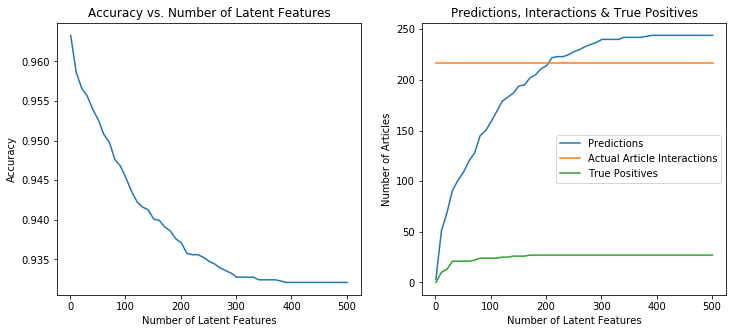

In [46]:
# Test predictions for different numbers of latent features
num_latent_feats = np.arange(1,500+10,10)
sum_errs, total_preds, true_positives, actual_interactions = [], [], [], []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # select rows for users we can make predictions for
    user_item_est = user_item_est[test_user_rows]
    
    # select items we can make predictions for
    user_item_est = user_item_est[:, test_user_cols]
    
    # compute number of predictions made, actual interactions and true positives
    total_preds.append(np.sum(user_item_est))
    actual_interactions.append(np.sum(np.array(user_item_test_subset)))
    true_positives.append(user_item_est[np.equal(np.array(user_item_test_subset), user_item_est)].sum())
   
    
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
print(total_preds, true_positives)
    
# Visualize results
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
    
ax0.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0])
ax0.set_xlabel('Number of Latent Features')
ax0.set_ylabel('Accuracy')
ax0.set_title('Accuracy vs. Number of Latent Features')

ax1.plot(num_latent_feats, total_preds, label='Predictions')
ax1.plot(num_latent_feats, actual_interactions, label='Actual Article Interactions')
ax1.plot(num_latent_feats, true_positives, label='True Positives')
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('Number of Articles')
ax1.legend(loc='center right')
ax1.set_title('Predictions, Interactions & True Positives');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

>The visualization of 'Accuracy vs. Number of Latent Features' shows two rather surprising results:
>
>1. The accuracy drastically decreases with a higher number of latent features used.
>2. The accuracy of the predictions is extremly high, with an accuracy rate between 0.933 and 0.97.
>
>In order to better understand these results I created a second graph that plots the number of predictions made, the number of true positives (actual article interactions that were also predicted correctly), and the number of article interactions versus the number of latent features used. 
>
>The graph shows that the number of predictions increases with the number of latent features, while the number of true positives quickly reaches its max of 27 correctly predicted article interactions. Because of this, the accuracy rate decreases with a higher number of latent features.
>
>The high accuracy rate especially with a low number of latent features can be explained by the low proportion of articles the users in the test set actually interacted with. With a mean of 10.85 interactions out of 574 articles, this proportion of interactions is actually only 0.0189, so when we make only very few predictions (or even no predictions at all), the accuracy rate will always be very high.
>
>In addition, we must take into account that the test set which we can make predictions for using our matrix consist of only 20 users, so this test set is really not a good basis for a sound evaluation of our recommendation system.
>
>Apart from that, there is a more fundamental fault in our evaluation metrics. The dataset only contains information whether a user has interacted with an article or not, but only that he or she hasn't interacted with an article doesn't necessarily mean that the article isn't of interest for that user. Maybe the user would be extremly interested in the content, but simply didn't have a chance to see it yet (due to lack of a good recommender system).
>
>To really find out if our recommendation systems are an improvement to how users currently find articles, we would need a different evaluation metrics. One possibility would be to use A/B testing and measure e.g. if the number of article interactions (or other measures like reading time) increase by using certain recommendation engines.

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0